In [1]:
import pandas as pd
import requests
import json
import re, string, timeit
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = None # show all columns in display

In [3]:
def get_api_key(api_key_id = "Domain"):
  """
  Get the api key for website accessing.

  Table of key type and key value for privacy.

  Parameters
  ----------
  @api_key_id [string]: Key value in dataframe

  Returns
  -------
  [string]: client_id & client_secret

  """
  # load api keys file
  df_api_keys = pd.read_csv('~/Documents/Python/api_keys.csv', header = 'infer')
  
  # return api key if in dataset
  try:
    # get api key from id
    client_id = df_api_keys.loc[df_api_keys['Id'] == api_key_id]['Client'].iloc[0] # get client by id
    client_secret = df_api_keys.loc[df_api_keys['Id'] == api_key_id]['Secret'].iloc[0] # get secret by id
    # return api key
    return client_id, client_secret
  except IndexError:
    # get api key id list
    api_key_id_list = df_api_keys['Id'].unique().tolist()
    # print error message
    print('Cannot map key. Api key id must be one of the following options {0}'.format(api_key_id_list))

In [4]:
# POST request for token
client_id, client_secret = get_api_key(api_key_id="Domain")
response = requests.post('https://auth.domain.com.au/v1/connect/token', data = {'client_id':client_id,"client_secret":client_secret,"grant_type":"client_credentials","scope":"api_listings_read","Content-Type":"text/json"})
token=response.json()
access_token=token["access_token"]

In [5]:
property_id="2016806821"
#domain_api_key = get_api_key(api_key_id = "Domain")
# GET Request for ID
url = "https://api.domain.com.au/v1/listings/"+property_id
auth = {"Authorization":"Bearer "+access_token}
request = requests.get(url,headers=auth)
r=request.json()

In [6]:
#get details
da=r['addressParts']
postcode=da['postcode']
suburb=da['suburb']
bathrooms=r['bathrooms']
bedrooms=r['bedrooms']
carspaces=r['carspaces']
property_type=r['propertyTypes']
area=r['landAreaSqm']
geolocation=r['geoLocation']
print(property_type, postcode, suburb, bedrooms, bathrooms,  carspaces, area, geolocation)

# the below puts all relevant property types into a single string. eg. a property listing can be a 'house' and a 'townhouse'
n=0
property_type_str=""
for p in r['propertyTypes']:
  property_type_str=property_type_str+(r['propertyTypes'][int(n)])
  n=n+1
print(property_type_str) 

['house'] 2640 Thurgoona 3.0 1.0 2.0 850.0 {'latitude': -36.0488277, 'longitude': 146.9899849}
house


In [7]:
def api_property_list_sold(auth, property_type, bedrooms, bathrooms, suburb, postcode):
  # url for api
  url = "https://api.domain.com.au/v1/listings/residential/_search"

  # enter parameters
  post_fields ={
      "listingType":"Sold",
        "maxPrice":"",
        "pageSize":200,
      "propertyTypes":property_type,
      "minBedrooms":"",
        "maxBedrooms":"",
      "minBathrooms":"",
        "maxBathrooms":"",
      "locations":[
        {
          "state":"",
          "region":"",
          "area":"",
          "suburb":suburb,
          "postCode":postcode,
          "includeSurroundingSuburbs":False
        }
      ]
    }

  # response
  response = requests.post(url,headers=auth,json=post_fields)
  #response = requests.request("GET", url, headers=headers, params=querystring)
  return response.json()

In [8]:
def process_list_sold_response(response_json):
    """
    Process the list for sale API response.

    Convert each listing to a dataframe, append to a list, and concatenate to one dataframe.

    Parameters
    ----------
    @response_json [dictionary]: API response for list for sale

    Returns
    -------
    [dataframe] Dataframe of all list for sale responses

    """

    # empty dataframe
    dataframe_list = []

    # iterate through each for sale listing
    
    for j in range(len(response_json)):
        response_json[j]['listing']['propertyDetails']
        k = response_json[j]['listing']['propertyDetails'].copy()
        k['id']  = response_json[j]['listing']['id']
        if "soldPrice" in response_json[j]['listing']['soldData']:
            k['sold_price']  = response_json[j]['listing']['soldData']['soldPrice']
        else:
            k['sold_price']  = "NA"
        #k['sold_price'] = response.json[j]['listing']['hasVideo']
        # convert each listing to dataframe 
        _temp_df = pd.DataFrame.from_dict(k, orient='index').T

        # append to dataframe list for all listings
        dataframe_list.append(_temp_df)
    
        # concatenate all dataframes, for missing col values enter null value
    return pd.concat(dataframe_list, axis=0, ignore_index=True, sort=False)

In [9]:
property_list_sold_response = api_property_list_sold(auth, property_type, bedrooms, bathrooms, suburb, postcode)
property_list_sold_response[0:3]

[{'type': 'PropertyListing',
  'listing': {'listingType': 'Sold',
   'id': 2016921749,
   'advertiser': {'type': 'Agency',
    'id': 11631,
    'name': 'Stean Nicholls Pty Ltd',
    'logoUrl': 'https://images.domain.com.au/img/Agencys/11631/logo_11631.GIF',
    'preferredColourHex': '#000033',
    'bannerUrl': 'https://images.domain.com.au/img/Agencys/11631/banner_11631.GIF',
    'contacts': [{'name': 'Jack Stean',
      'photoUrl': 'https://images.domain.com.au/img/11631/contact_1400351.jpeg?mod=210507-144742'},
     {'name': 'Mikaela Gould',
      'photoUrl': 'https://images.domain.com.au/img/11631/contact_1794690.jpeg?mod=210507-144742'}]},
   'priceDetails': {'price': 631000,
    'priceFrom': 631000,
    'priceTo': 631000,
    'displayPrice': '$631,000'},
   'media': [{'category': 'Image',
     'url': 'https://bucket-api.domain.com.au/v1/bucket/image/2016921749_1_1_210408_054648-w2500-h1667'},
    {'category': 'Image',
     'url': 'https://bucket-api.domain.com.au/v1/bucket/image/2

In [10]:
df_properties_sold_raw = process_list_sold_response(response_json=property_list_sold_response)
df_properties_sold_raw = df_properties_sold_raw.drop(['allPropertyTypes','buildingArea'], axis = 1)
df_properties_sold_raw = df_properties_sold_raw[df_properties_sold_raw.sold_price !="NA"]
df_properties_sold_raw = df_properties_sold_raw.dropna()
df_properties_sold_raw.landArea = df_properties_sold_raw.landArea.astype(int)
df_properties_sold_raw.sold_price = df_properties_sold_raw.sold_price.astype(int)
df_properties_sold_raw.bathrooms = df_properties_sold_raw.bathrooms.astype(int)
df_properties_sold_raw.bedrooms = df_properties_sold_raw.bedrooms.astype(int)
df_properties_sold_raw.carspaces = df_properties_sold_raw.carspaces.astype(int)
df_properties_sold_raw['URL'] = 'http://www.domain.com.au/' + df_properties_sold_raw.id.apply(str)

In [11]:

df_properties_sold_raw.to_csv("output/Sold_Properties.csv", index = False)

In [12]:
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}"">{}</a>'.format(val, val)

In [13]:
df_properties_sold = df_properties_sold_raw.style.format({'URL': make_clickable})
df_properties_sold

,state,features,propertyType,bathrooms,bedrooms,carspaces,unitNumber,streetNumber,street,area,region,suburb,postcode,displayableAddress,latitude,longitude,landArea,id,sold_price,URL
0,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Heating', 'Study']",House,2,4,3,,47,Hereford Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"47 Hereford Court, Thurgoona",-36.063880,147.011810,1521,2016921749,631000,http://www.domain.com.au/2016921749
1,NSW,"['AirConditioning', 'BuiltInWardrobes', 'SecureParking', 'BroadbandInternetAccess', 'Heating', 'Dishwasher', 'Shed', 'FullyFenced']",House,1,3,3,,3,Gleneagles Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"3 Gleneagles Court, Thurgoona",-36.052814,146.992584,1215,2016883542,430000,http://www.domain.com.au/2016883542
2,NSW,"['AirConditioning', 'Ensuite', 'Gas', 'SecureParking', 'Heating', 'Dishwasher', 'Shed', 'SolarPanels']",House,2,4,2,,11,Dryandra Way,Albury - Greater Region,Regional NSW,THURGOONA,2640,"11 Dryandra Way, Thurgoona",-36.053066,146.981628,765,2016894926,580000,http://www.domain.com.au/2016894926
3,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'SecureParking', 'Heating', 'Dishwasher', 'Shed', 'SolarPanels', 'GardenCourtyard']",House,2,4,3,,65,Newton Circuit,Albury - Greater Region,Regional NSW,THURGOONA,2640,"65 Newton Circuit, Thurgoona",-36.045918,147.003815,840,2016883193,800000,http://www.domain.com.au/2016883193
4,NSW,"['BuiltInWardrobes', 'Ensuite', 'Gas', 'SecureParking', 'Bath', 'Heating', 'Dishwasher', 'Study']",House,2,4,2,,61,Riverboat Drive,Albury - Greater Region,Regional NSW,THURGOONA,2640,"61 Riverboat Drive, Thurgoona",-36.057117,146.977448,651,2016896886,670000,http://www.domain.com.au/2016896886
5,NSW,"['Ensuite', 'Gas', 'SecureParking', 'Heating']",House,2,4,2,,36,Stockman Circuit,Albury - Greater Region,Regional NSW,THURGOONA,2640,"36 Stockman Circuit, Thurgoona",-36.055607,147.010635,925,2016798090,585000,http://www.domain.com.au/2016798090
6,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'Gas', 'SecureParking', 'BroadbandInternetAccess', 'Heating', 'Dishwasher', 'Shed']",House,2,4,2,,10,Lindisfarne Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"10 Lindisfarne Court, Thurgoona",-36.054200,146.997559,721,2016841907,418870,http://www.domain.com.au/2016841907
7,NSW,"['Dishwasher', 'Shed']",House,1,3,1,,37,Hotham Cct,Albury - Greater Region,Regional NSW,THURGOONA,2640,"37 Hotham Cct, Thurgoona",-36.048275,146.991257,703,2016760172,330000,http://www.domain.com.au/2016760172
8,NSW,"['Ensuite', 'Gas', 'SecureParking', 'NorthFacing', 'Heating']",House,2,4,2,,11,Belah Court,Albury - Greater Region,Regional NSW,THURGOONA,2640,"11 Belah Court, Thurgoona",-36.051617,146.977753,651,2016828439,470000,http://www.domain.com.au/2016828439
9,NSW,"['AirConditioning', 'BuiltInWardrobes', 'Ensuite', 'SecureParking', 'SwimmingPool', 'Heating', 'Study']",House,2,4,2,,20,Whittler Road,Albury - Greater Region,Regional NSW,THURGOONA,2640,"20 Whittler Road, Thurgoona",-36.025080,146.985428,665,2016823788,675000,http://www.domain.com.au/2016823788


Data Exploration

In [14]:
df_properties_sold_raw.sold_price.describe()

count    1.880000e+02
mean     4.849232e+05
std      1.602427e+05
min      2.300000e+05
25%      3.822500e+05
50%      4.475000e+05
75%      5.650000e+05
max      1.200000e+06
Name: sold_price, dtype: float64

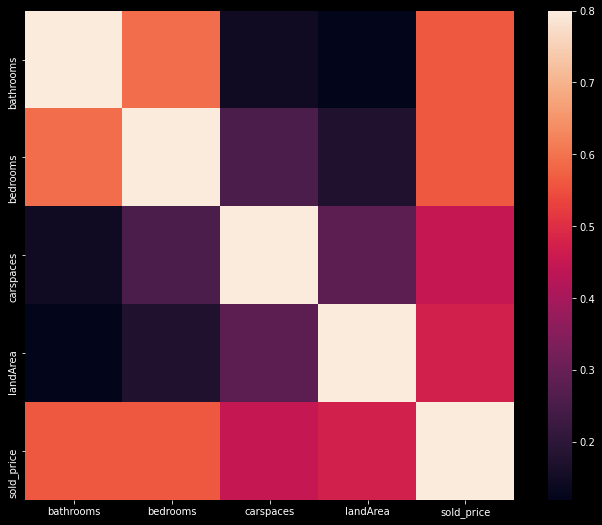

In [15]:
import matplotlib.pyplot as plt

corrmat = df_properties_sold_raw.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [16]:
import plotly.express as px

fig = px.scatter_mapbox(df_properties_sold_raw, lat="latitude", lon="longitude", hover_name="id",size = "sold_price", hover_data=["propertyType", "bedrooms", "bathrooms", "landArea"],zoom=15, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()